In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm.notebook import tqdm
import random
from sklearn.neural_network import MLPClassifier
from collections import Counter

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
# import nltk

from utils import *
import copy
from sklearn import tree
import sklearn

from models.synthetic_models import *
from models.train_synthetic import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

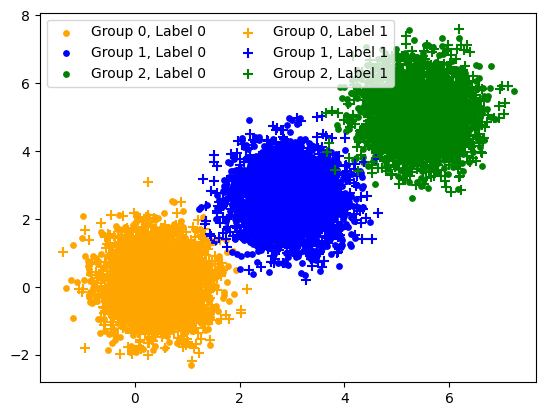

In [26]:

total=10000
n_groups = 3
X, y, groups, mu, sig = getSyntheticDataset(total, n_groups=n_groups)

import itertools
colors = ["orange", "blue", "green", "gray"]
markers = [".", "+"]

total = len(X)
indices = list(range(len(X)))
random.shuffle(indices)

for label, group in itertools.product(np.unique(y), np.unique(groups)):
    x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
    x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
#     print (x1,x2)
    
    leg = "Group " + str(group) + ", Label " + str(label)
    plt.scatter(x1, x2, marker=markers[label], label=leg, s=60, c=colors[group])
plt.legend(ncol=2)

## Parameters

In [27]:
NUM_EXPERTS = 3

## Synthetic experts
experts = getUniformExperts(n_groups)
expert_costs = np.array([0,0,0])

np.random.seed(1026)

train, test = getPartition(frac=0.7, total=total)
lambda_cost = 0.01
dropout = 0

input_size = 2
output_size = NUM_EXPERTS
s = 0.4
sL = s
sU = 1-s

### Get initial allocation model for Strict-Matching; this model is pre-trained to simulate dSim

In [28]:
## Since dSim will be different for each s, we need a separate initial deferrer model for each s

deferrer_prior = {}
for s in (np.linspace(0.33, 1, 10)):
    sL = (1-s)/2
    sU = s
    random.shuffle(train)
    deferrer_prior[s] = getDeferrerWithPrior(input_size, output_size, X, groups, train[:500], experts, sU, sL)                      
    

## Online Learning

### Run the evaluation process #reps times with random train-test split each time

In [ ]:
reps = 50
algorithm = "Smooth-Matching" ## replace with "Strict-Matching" when using that algorithm

wts_all_0, wts_all_1, wts_all_2, all_accs = [], [], [], []

for rep in (range(reps)):
    print ("Starting rep", rep)
    
    train, test = getPartition(frac=0.7, total=total)
    random.shuffle(train)

    accs, c_accs = [], []    
    wts_0, wts_1, wts_2 = [], [], []
    
    ## evaluate algorithm for different noise level (s) in dSim
    for s in (np.linspace(0.33, 1, 10)): 
        sL = (1-s)/2
        sU = s

        if algorithm == "Strict-Matching":
            deferrer = copy.deepcopy(deferrer_prior[s])
        else:
            deferrer = [copy.deepcopy(getDeferrer_expert(input_size)) for _ in range(NUM_EXPERTS)]
    
        ## Train the allocation model using the specified algorithm and train partition
        deferrer = train_allocation(X, y, groups, deferrer, algorithm, train, experts, sU, sL)
               
        ## Test the trained model on held-out test data
        acc, wts = test_allocation(X, y, groups, deferrer, test, experts, sU, sL, n_groups)
            
        testGroups = [int(groups[i]) for i in test]    
        wts_0.append(np.mean([w for i, w in enumerate(wts) if testGroups[i] == 0], axis=0))
        wts_1.append(np.mean([w for i, w in enumerate(wts) if testGroups[i] == 1], axis=0))  
        wts_2.append(np.mean([w for i, w in enumerate(wts) if testGroups[i] == 2], axis=0))       
        accs.append(acc)
        
            
    wts_all_0.append(wts_0)
    wts_all_1.append(wts_1)
    wts_all_2.append(wts_2)        


    all_accs.append(list(accs))


Text(0.5, 0, 'dSim parameter $s$')

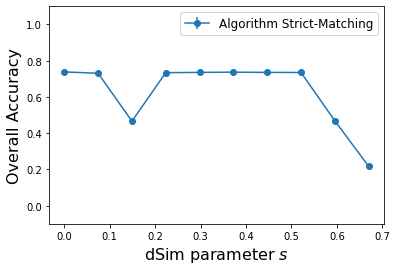

In [69]:
all_accs_strict = list(all_accs)
wts_all_0_strict = list(wts_all_0)
wts_all_1_strict = list(wts_all_1)
wts_all_2_strict = list(wts_all_1)

# all_accs_smooth = list(all_accs)
# wts_all_0_smooth = list(wts_all_0)
# wts_all_1_smooth = list(wts_all_1)
# wts_all_2_smooth = list(wts_all_1)

# xs = np.linspace(0.33, 1, 20)
# accs_mean = dict(zip(1-xs, np.mean(all_accs_smooth, axis=0)))
# accs_std = dict(zip(1-xs, np.std(all_accs_smooth, axis=0)))

# plt.errorbar(accs_mean.keys(), accs_mean.values(), accs_std.values(), fmt="-o", label="Algorithm Smooth-Matching")

xs = np.linspace(0.33, 1, 10)
accs_mean = dict(zip(1-xs, np.mean(all_accs_strict, axis=0)))
accs_std = dict(zip(1-xs, np.std(all_accs_strict, axis=0)))

plt.errorbar(accs_mean.keys(), accs_mean.values(), accs_std.values(), fmt="-o", label="Algorithm Strict-Matching")

plt.legend(fontsize=12)
plt.ylim([-0.1,1.1])
plt.ylabel("Overall Accuracy", fontsize=16)
plt.xlabel("dSim parameter $s$", fontsize=16)